# 1. AUTOGRAD: AUTOMATIC DIFFERENTIATION:

Central to all neural networks in PyTorch is the **autograd** package. Let’s first briefly visit this, and we
will then go to training our first neural network.
    
The **autograd** package provides automatic differentiation for all operations on Tensors. It is a define-by-
run framework, which means that your backprop is defined by how your code is run, and that every single 
iteration can be different.

## 1.1. Create a tensor and set requires_grad=True to track computation with it:
torch.Tensor is the central class of the package. If you set its attribute **.requires_grad** as **True**, it starts to track all operations on it. When you finish your computation you can call **.backward()** and have all the gradients computed automatically. The gradient for this tensor will be accumulated into **.grad** attribute.

define a function:  
x = \[[1,1],[1,1]]  
y = x + 2  
z = y ^ 2 * 3  
out = z.mean()  

In [1]:
import torch

# create a tensor with setting its .requires_grad as Ture
x = torch.ones(2, 2, requires_grad=True)
print(x)

x1 = torch.ones(2,2,requires_grad=False)
# x1.requires_grad_(True)
print(x1)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[1., 1.],
        [1., 1.]])


## 1.2. Do a tensor operation:

In [2]:
y = x + 2
print(y)

y1 = x1 + 2
print(y1)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
tensor([[3., 3.],
        [3., 3.]])


y was created as a result of an operation, so it has a grad_fn.But y1 not

In [3]:
print(y.grad_fn)
print(y1.grad_fn)

None


## 1.3. Do more operations on y

In [4]:
z = y * y * 3
z1 = y1 * y1 * 3
out = z.mean()   #calculate z average value
out1 = z1.mean()   #calculate z1 average value

print(z, out)
print(z1, out1)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward1>)
tensor([[27., 27.],
        [27., 27.]]) tensor(27.)


**.requires_grad_( )** changes an existing Tensor’s requires_grad flag in-place. The input flag defaults to False if not given.

Tensor and Function are interconnected and build up an acyclic graph, that encodes a complete history of 
computation. Each tensor has a .grad_fn attribute that references a Function that has created the Tensor 
(**except for Tensors created by the user - their grad_fn is None**).

In [5]:
a = torch.randn(2, 2)    # a is created by user, its .grad_fn is None
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)   # change the attribute .grad_fn of a
print(a.requires_grad)
b = (a * a).sum()        # add all elements of a  to b
print(b.grad_fn)

False
True


# 2. Gradients:

## 2.1. Let’s backprop now. 
Because out contains a single scalar, **out.backward( )** is equivalent to **out.backward(torch.tensor(1.))**

In [6]:
out.backward()
# out.backward(torch.tensor(1.))
# out1.backward()

you can get parameters gradient like below:

In [7]:
x_grad = x.grad
y_grad = y.grad
z_grad = z.grad
print(x_grad)
print(y_grad)
print(z_grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
None
None


## 2.2. Now let’s take a look at an example of Jacobian-vector product:
If you want to compute the derivatives, you can call **.backward( )** on a Tensor. If Tensor is a **scalar** (i.e. it holds a one element data), you don’t need to specify any arguments to backward( ), however if it has more elements, you need to specify a gradient argument that is a tensor of matching shape.

define a function:  
x = \[1, 1, 1]  
y = x + \[1, 2, 3]  
z = y ^ 3

In [33]:
x = torch.ones(3, requires_grad=True)
y = x + torch.tensor([1., 2., 3.])
z = y * y * y
print(z)

v = torch.tensor([1, 2., 3.])
# z is a vector, so you need to specify a gradient whose size is the same as z
z.backward(v)    
print(x.grad)

tensor([ 8., 27., 64.], grad_fn=<MulBackward0>)
tensor([ 12.,  54., 144.])


## 问题1：
**传入 .backward()里面的tensor是什么？请尝试不同的输入并回答。**

your answer...

在.backward(parameters)函数中，参数parameters表示对叶子节点自动求偏导之后得到的梯度$grad(t1,t2,t3……)$向量中各偏导的加权值。比如，上述代码表示的数学含义为，$x=(x_1,x_2,x_3),y=(x_1+1,x_2+2,x_3+3),z=((x_1+1)^3,(x_2+2)^3,(x_3+3)^3)$，在调用z.backward()之后(假设此时v=torch.tensor([1, 1., 1.]))，对叶子节点求导之后可知，x.grad=tensor([12., 27., 48.]);如果我们设置v=torch.tensor([1, 2., 3.])，则x.grad=tensor([ 12.,  54., 144.])


# 3. NEURAL NETWORKS

A typical training procedure for a neural network is as follows:
    
- Define the neural network that has some learnable parameters (or weights)
- Iterate over a dataset of inputs
- Process input through the network
- Empty the parameters in optimizer
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient


## 3.1. Define the network
Let’s define a network to classify points of gaussian distribution to three class

### 3.1.1. Show all points
Show all points(containing trainset and testset) you will use

In [9]:
# show all points, you can skip this cell
def show_original_points():
    label_csv = open('./labels/label.csv', 'r')
    label_writer = csv.reader(label_csv)
    class1_point = []
    class2_point = []
    class3_point = []
    for item in label_writer:
        if item[2] == '0':
            class1_point.append([item[0], item[1]])
        elif item[2] == '1':
            class2_point.append([item[0], item[1]])
        else:
            class3_point.append([item[0], item[1]])
    data1 = np.array(class1_point, dtype=float)
    data2 = np.array(class2_point, dtype=float)
    data3 = np.array(class3_point, dtype=float)
    x1, y1 = data1.T
    x2, y2 = data2.T
    x3, y3 = data3.T
    plt.figure()
    plt.scatter(x1, y1, c='b', marker='.')
    plt.scatter(x2, y2, c='r', marker='.')
    plt.scatter(x3, y3, c='g', marker='.')
    plt.axis()
    plt.title('scatter')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

### 3.1.2. Define a network
When you define a network, your class must to inherit **nn.Moudle**, then you should to overload **\_\_init__** method and **forward** method

Network(  
    (hidden): Linear(in_features=2, out_features=5, bias=True)  
    (sigmiod): Sigmoid()  
    (predict): Linear(in_features=5, out_features=3, bias=True)  
)  

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import time
import csv
import numpy as np

In [69]:
class Network(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        '''
        Args:
            n_feature(int): size of input tensor
            n_hidden(int): size of hidden layer 
            n_output(int): size of output tensor
        '''
        super(Network, self).__init__()
        # define a liner layer
        self.hidden = nn.Linear(n_feature, n_hidden)
        # define sigmoid activation 
        self.sigmoid = nn.Sigmoid()
        self.predict = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        '''
        x(tensor): inputs of the network
        '''
        # hidden layer
        h1 = self.hidden(x)
        # activate function
        h2 = self.sigmoid(h1)
        # output layer
        out = self.predict(h2)
        '''
        Linear classifier often follows softmax to output probability,
        however the loss function CrossEntropy we used have done this 
        operation, so we don't use softmax function here.
        '''
        return out

CrossEntropy written in pytorch:
[https://pytorch.org/docs/stable/nn.html?highlight=crossentropy#torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html?highlight=crossentropy#torch.nn.CrossEntropyLoss)

### 3.1.3. Overload a Dataset
Please skip the below cell when you are trying to train a model

In [70]:
class PointDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        '''
        Args:
            csv_file(string): path of label file
            transform (callable, optional): Optional transform to be applied
                on a sample.
        '''
        self.frame = pd.read_csv(csv_file, encoding='utf-8', header=None)
#         print('csv_file source ---->', csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        x = self.frame.iloc[idx, 0]
        y = self.frame.iloc[idx, 1]
        point = np.array([x, y])
        label = int(self.frame.iloc[idx, 2])
        if self.transform is not None:
            point = self.transform(point)
        sample = {'point': point, 'label': label}
        return sample

### 3.1.4. Train function
Train a model and show running_loss curve ana show accuracy curve

In [76]:
def train(classifier_net, trainloader, testloader, device, lr, optimizer):
    '''
    Args:
        classifier_net(nn.model): train model
        trainloader(torch.utils.data.DateLoader): train loader
        testloader(torch.utils.data.DateLoader): test loader
        device(torch.device): the evironment your model training
        LR(float): learning rate
    '''
    # loss function
    criterion = nn.CrossEntropyLoss().to(device)
    
    optimizer = optimizer
    
    # save the mean value of loss in an epoch
    running_loss = []
    
    running_accuracy = []
    
    # count loss in an epoch 
    temp_loss = 0.0
    
    # count the iteration number in an epoch
    iteration = 0 

    for epoch in range(epoches):
        
        '''
        adjust learning rate when you are training the model
        '''
        # adjust learning rate
        # if epoch % 100 == 0 and epoch != 0:
        #     LR = LR * 0.1
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = LR

        for i, data in enumerate(trainloader):
            point, label = data['point'], data['label']
            point, label = point.to(device).to(torch.float32), label.to(device)
            outputs = classifier_net(point)
            '''# TODO'''
            optimizer.zero_grad()
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            '''# TODO END'''
            
            # save loss in a list
            temp_loss += loss.item()
            iteration +=1
            # print loss value 
#             print('[{0:d},{1:5.0f}] loss {2:.5f}'.format(epoch + 1, i, loss.item()))
            #slow down speed of print function
            # time.sleep(0.5)
        running_loss.append(temp_loss / iteration)
        temp_loss = 0
        iteration = 0
#         print('test {}:----------------------------------------------------------------'.format(epoch))
        
        # call test function and return accuracy
        running_accuracy.append(predict(classifier_net, testloader, device))
    
    # show loss curve
    show_running_loss(running_loss)
    
    # show accuracy curve
    show_accuracy(running_accuracy)
    
    return classifier_net

## 问题2:
根据本节前面提到的训练一个网络的完整流程，将下面的代码按照正确的顺序填写到train()函数里面的 **\# TODO** 里面  

\# update paraeters in optimizer(update weigtht)  
**optimizer.step()**  


\# calcutate loss value  
**loss = criterion(outputs, label)** 


\# empty parameters in optimizer  
**optimizer.zero_grad()**  

            
\# back propagation  
**loss.backward()**  





In [77]:
# show running loss curve, you can skip this cell.
def show_running_loss(running_loss):
    # generate x value
    x = np.array([i for i in range(len(running_loss))])
    # generate y value
    y = np.array(running_loss)
    # define a graph
    plt.figure()
    # generate curve
    plt.plot(x, y, c='b')
    # show axis
    plt.axis()
    # define title
    plt.title('loss curve:')
    #define the name of x axis
    plt.xlabel('step')
    plt.ylabel('loss value')
    # show graph
    plt.show()

### 3.1.5. Test function
Test the performance of your model 

In [81]:
def predict(classifier_net, testloader, device):
#     correct = [0 for i in range(3)]
#     total = [0 for i in range(3)]
    correct = 0
    total = 0
    
    with torch.no_grad():
        '''
        you can also stop autograd from tracking history on Tensors with .requires_grad=True 
        by wrapping the code block in with torch.no_grad():
        '''
        for data in testloader:
            point, label = data['point'], data['label']
            point, label = point.to(device).to(torch.float32), label.to(device)
            outputs = classifier_net(point)
            '''
            if you want to get probability of the model prediction,
            you can use softmax function here to transform outputs to probability.
            '''
            # transform the prediction to one-hot form
            _, predicted = torch.max(outputs, 1)
#             print('model prediction: ', predicted)
#             print('ground truth:', label, '\n')
            correct += (predicted == label).sum()
            total += label.size(0)
#             print('current correct is:', correct.item())
#             print('current total is:', total)
            
#         print('the accuracy of the model is {0:5f}'.format(correct.item()/total))
        
    return correct.item() / total

In [82]:
# show accuracy curve, you can skip this cell.
def show_accuracy(running_accuracy):
    x = np.array([i for i in range(len(running_accuracy))])
    y = np.array(running_accuracy)
    plt.figure()
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('accuracy curve:')
    plt.xlabel('step')
    plt.ylabel('accuracy value')
    plt.show()

### 3.1.6. Main function

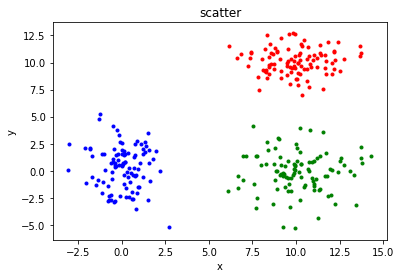

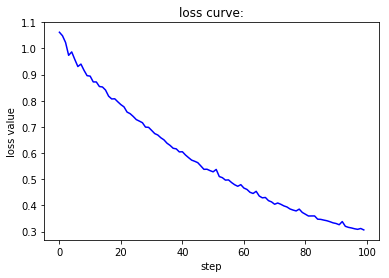

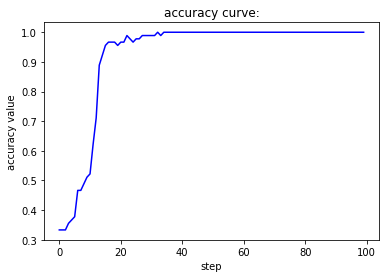

In [87]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

# 问题3:
**请尝试调整不同大小的学习率，观察loss曲线和accuracy曲线，并阐述学习率对loss值以及accuracy值的影响和原因。**

your answer...
我分别调整学习率为$10^{-4}、10^{-2}、10^{-1}、0.2$，最终预测结果如下，可以看出，除了$lr=10^{-4}$，其他不同的学习率情况下的预测正确率都可以达到1.0。同时，在训练的过程中：
①学习率越高所需的训练时间越少；
②学习率越高，loss曲线下降越快，最终都趋于平缓；
③学习率越高，accuracy曲线上升越快，但是，训练次数不够时跳出最优解的概率也最大。
出现这些情况的原因，可能是学习率越高，则梯度下降的越快，越容易找到最优解；但是没有发生拟合不足的情况，可能是因为测试级比较简单，训练结果都可以正常预测测试集中的数据；当学习率过低时，学习速率过慢，导致有限的学习次数不足以学习到训练集全部特征。

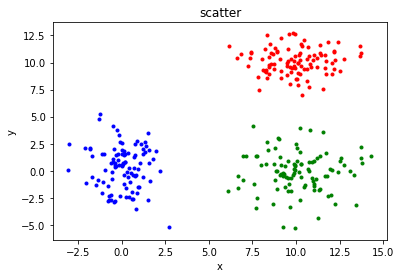

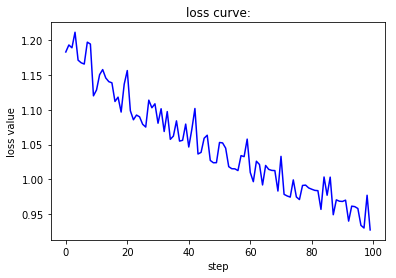

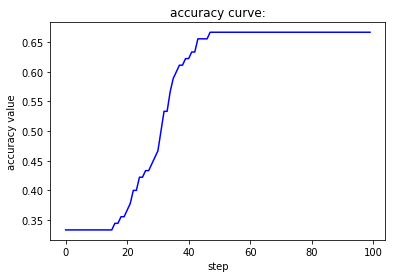

In [92]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-4
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

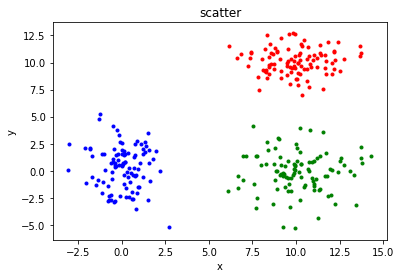

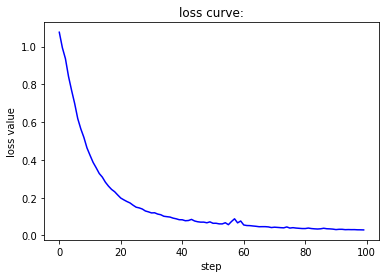

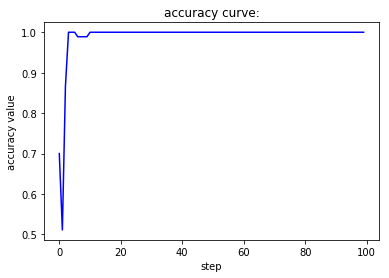

In [89]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-2
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

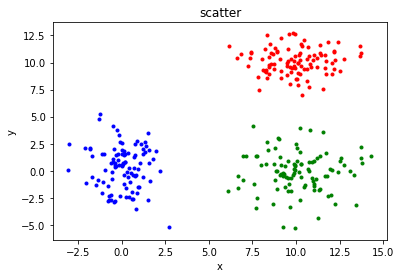

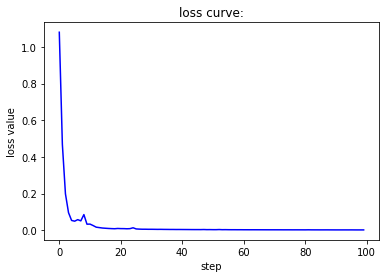

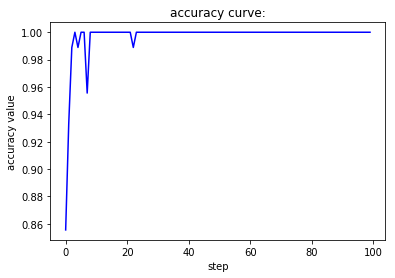

In [90]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-1
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

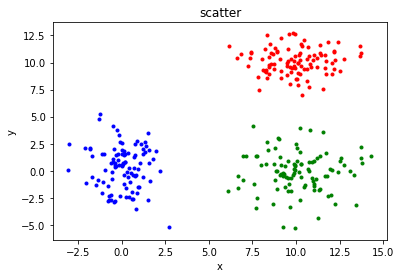

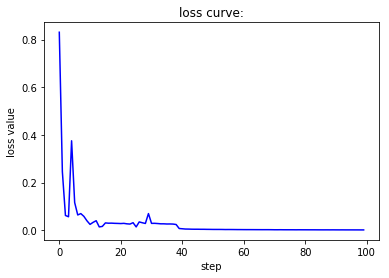

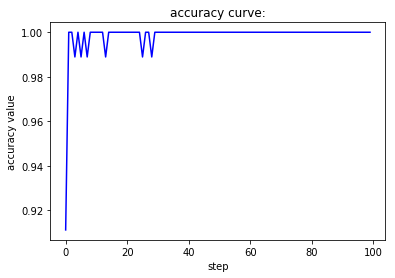

In [91]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 0.2
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

# 问题4:
**请尝试调整不同的batch_size, batch_size=1, batch_size=210,batch_size=（1~210）, 并阐述batch_size对loss值以及accuracy值的影响和原因。**

your answer...

我分别调整batch_size为1、64、180、210进行训练，得到以下结论：
①随着batch_size增加，训练时间逐渐变长。
②当batch_size为1时，loss曲线下降最快，其他三者下降速率趋于一致；
③随着batch_size的增大，accuracy最终值越来越小；只有batch_size=1时，accuracy最终达到了1，其他三者accuracy曲线上升较慢。
出现这样的情况的原因可能是，当batch_size=1时，即为随机梯度下降（SGD），一次只进行一次更新，速度较快，且容易跳出局部最优达到全局最优；当batch_size=64、180时，即为mini-batch Gradient Descent，一次进行部分更新，速度相对SGD来说较慢，batch_size过大时无法达到全局最优；当batch_size=210时，即为BGD，一次采用全部训练集的数据计算cost，导致训练缓慢，且在有限次数内可能无法到达全局最优，并陷入局部最优。

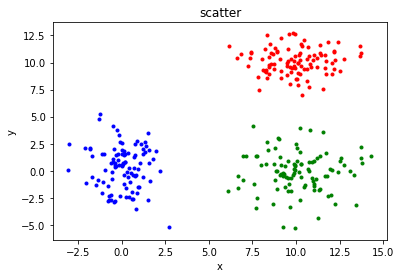

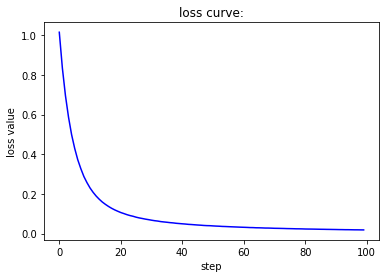

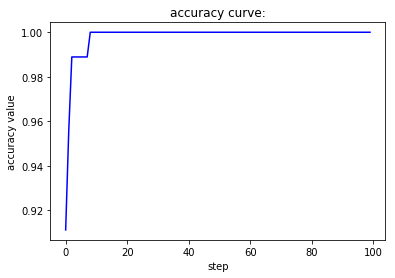

In [93]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 1
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

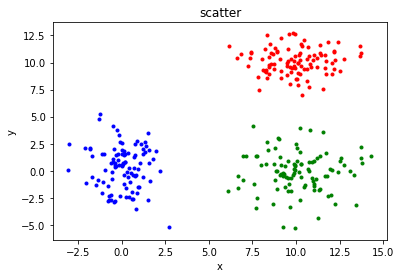

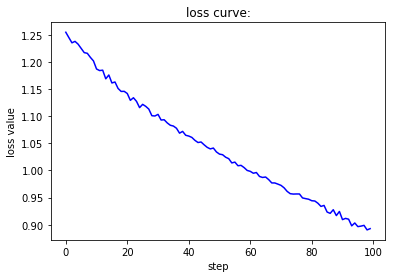

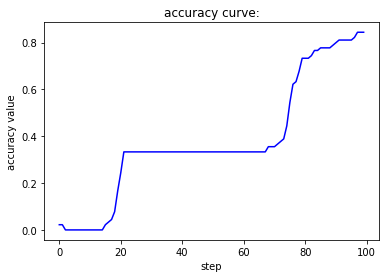

In [94]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 64
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

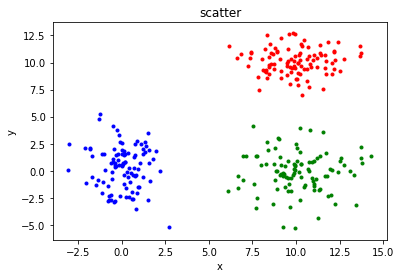

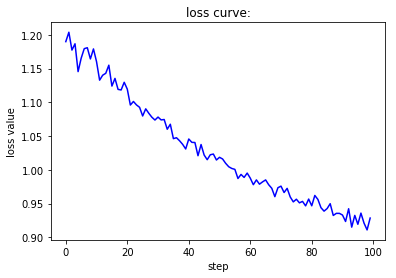

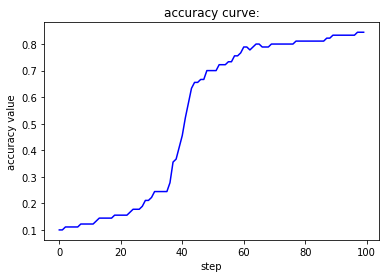

In [95]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 180
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

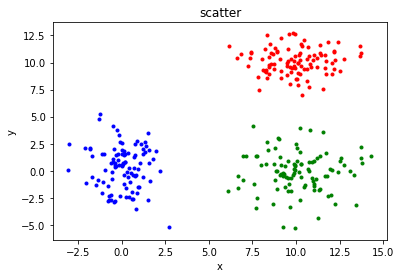

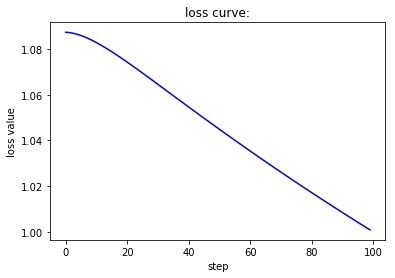

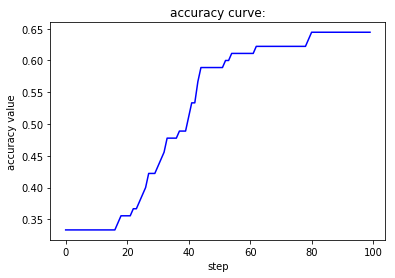

In [97]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 210
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

# 问题5:
**使用SGD优化器，并尝试momentum=0, momentum=0.9两种情况, 阐述momentum对loss值以及accuracy值的影响。**

your answer...

从下图中可以看出，当momentum=0.9时，loss曲线下降很快，并且最终可以达到最优解（accuracy=1）；但是当momentum=0时，loss曲线下降较慢，并且accuracy陷入了局部最优解。
原因: momentum的含义是动量；当我们抛出一个小球时，若小球处于的高度越高，则小球最终滚动的距离会更远，不会陷入中途的一些“坑”（局部最优）。在这个模型中，momentum也即为此含义，当momentum初始值越大，相当于给模型一个更大的动量，学习率更快，更容易跳出局部最优解，从而获得全局最优。

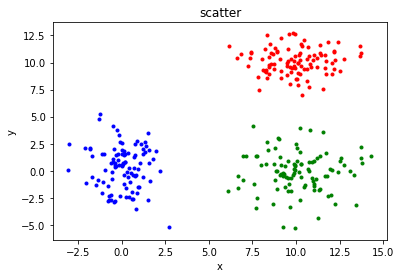

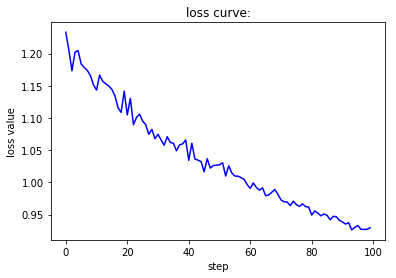

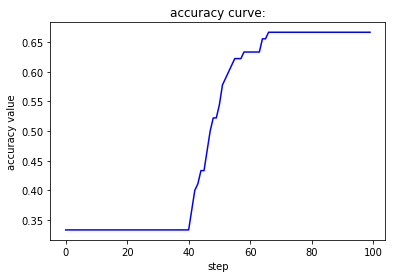

In [98]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

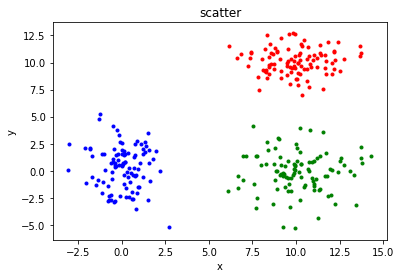

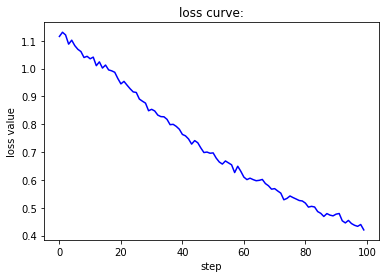

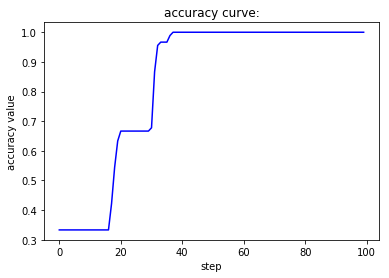

In [103]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

# 问题6:
**尝试使用Adam，Rprop优化器，观察两种曲线，阐述SGD,Adam,Rprop三种优化器对loss值以及accuracy值的影响.**

your answer...

从下面三幅图（SGD、Adam、Rprop）中可以看出，SGD和Adam优化情况大致类似，loss曲线平缓下降，accuracy在训练次数到20左右即可达到全局最优解。Rprop优化十分显著，loss曲线迅速下降，accuracy再开开始训练数轮之后达到全局最优。

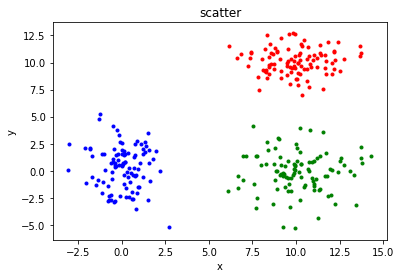

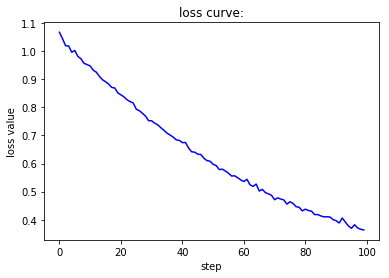

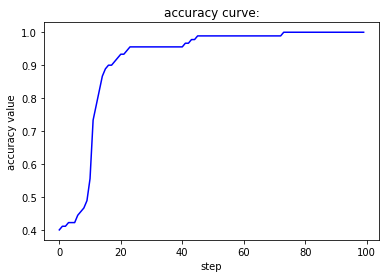

In [107]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

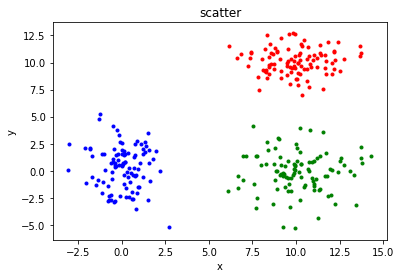

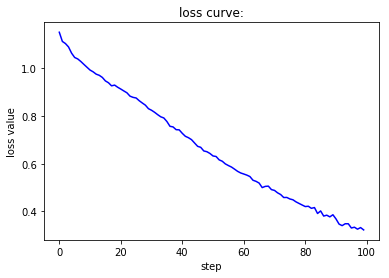

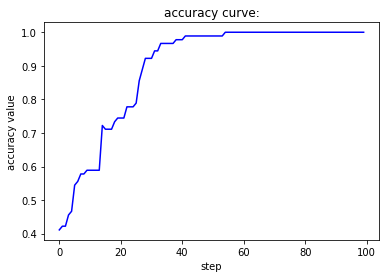

In [108]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.Adam(classifier_net.parameters(), lr=lr, betas=(0.9, 0.99))
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

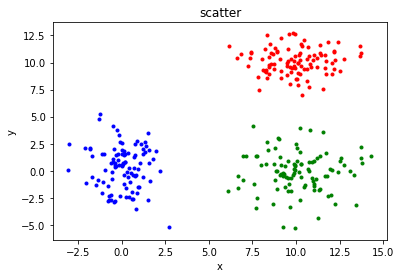

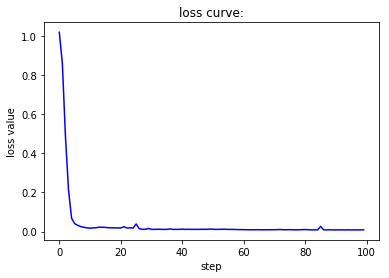

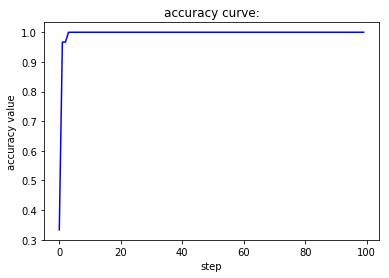

In [109]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = torch.optim.Rprop(classifier_net.parameters(), lr = lr)
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

# 问题7(自由发挥):
**尝试同时调节以上几种参数，找出你认为最合适的参数（模型收敛得最快），并就此谈谈你的感想.**

your answer...

在下述优化方案中，根据之前各种参数的调整，我使用SGD优化器（Rprop在此数据集上提升空间已经不大，所以没有使用），然后选择lr学习速率为0.01，batch_size为8，同时选取momentum=0.9,在保证训练速率的同时保证训练准确率，最终训练结果如下:

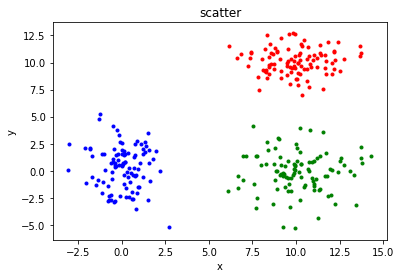

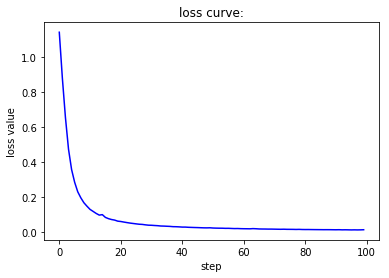

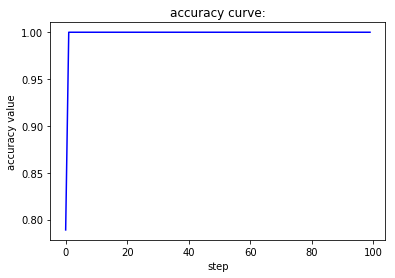

In [110]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-2
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 8
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

# 作业要求:


# 4. DATA LOADING AND PROCESSING TUTORIAL
# （Further content, read it when you are free）

A lot of effort in solving any machine learning problem goes in to preparing the data. PyTorch provides many tools to make data loading easy and hopefully, to make your code more readable. In this tutorial, we will see how to load and preprocess/augment data from a non trivial dataset.

## 4.1. To run this tutorial, please make sure the following packages are installed:
    
- scikit-image: For image io and transforms  

 - sudo apt-get install python-numpy  
 
 - sudo apt-get install python-scipy  
 
 - sudo apt-get install python-matplotlib 
 
 - sudo pip install  scikit-image  
    
- pandas: For easier csv parsing

 - sudo apt-get install python-pandas

In [18]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

plt.ion()   # interactive mode

## 4.2. Let’s quickly read the CSV and get the annotations in an (N, 2) array where N is the number of landmarks.

In [19]:
# read a csv file by pandas
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 0
# read image name, image name was saved in column 1.
img_name = landmarks_frame.iloc[n, 0]
# points were saved in columns from 2 to the end
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
# reshape the formate of points
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: 0805personali01.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[  27.   83.]
 [  27.   98.]
 [  29.  113.]
 [  33.  127.]]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


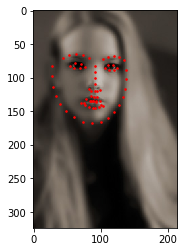

In [20]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

In [21]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        # combine the relative path of images 
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        # save all data we may need during training a network in a dict
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

### Note(very important):
to define a dataset, first we must to inherit the class **torch.utils.data.Dataset**. when we write ourselves dataset, it's neccesarry for us to overload the **\_\___init____** method, **\_\___len____** method, and **\_\___getitem____** method. Of course you can define other method as you like.

## 4.3. Let’s instantiate this class and iterate through the data samples. We will print the sizes of first 4 samples and show their landmarks.

0 (324, 215, 3) (68, 2)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


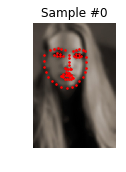

1 (500, 333, 3) (68, 2)


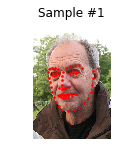

2 (250, 258, 3) (68, 2)


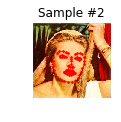

3 (434, 290, 3) (68, 2)


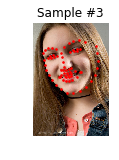

In [22]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    # create subgraph
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [29]:
import torch
import numpy as np
 
x1 = torch.from_numpy( 2*np.ones((2, 2), dtype=np.float32) )
x1.requires_grad_(True)
w1 = torch.from_numpy( 5*np.ones((2, 2), dtype=np.float32) )
w1.requires_grad_(True)
print("x1 =", x1)
print("w1 =", w1)
 
x2 = x1 * w1
w2 = torch.from_numpy( 6*np.ones((2,2), dtype=np.float32) )
w2.requires_grad_(True)
print("x2 =", x2)
print("w2 =", w2)
 
y = x2 * w2
Y = torch.from_numpy( 10*np.ones((2,2), dtype=np.float32) )
print("y =", y)
print("Y =", Y)
 
L = Y - y
print("L =", L)
L.backward(torch.ones(2, 2, dtype=torch.float))
print(x1.grad)
print(w1.grad)

x1 = tensor([[2., 2.],
        [2., 2.]], requires_grad=True)
w1 = tensor([[5., 5.],
        [5., 5.]], requires_grad=True)
x2 = tensor([[10., 10.],
        [10., 10.]], grad_fn=<MulBackward0>)
w2 = tensor([[6., 6.],
        [6., 6.]], requires_grad=True)
y = tensor([[60., 60.],
        [60., 60.]], grad_fn=<MulBackward0>)
Y = tensor([[10., 10.],
        [10., 10.]])
L = tensor([[-50., -50.],
        [-50., -50.]], grad_fn=<SubBackward0>)
tensor([[-30., -30.],
        [-30., -30.]])
tensor([[-12., -12.],
        [-12., -12.]])


# 5. More materials next week you may need
1. [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
2. [Save Model and Load Model](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
3. [Visualize your training phase](https://github.com/lanpa/tensorboardX)
4. [Exploding and Vanishing Gradients](http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/readings/L15%20Exploding%20and%20Vanishing%20Gradients.pdf)
5. [Gradient disappearance and gradient explosion in neural network training](https://bzdww.com/article/19659/)
6. [tensorboardX](https://github.com/lanpa/tensorboardX)